In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torchvision import datasets,transforms, models
import matplotlib.pyplot as plt

In [2]:
import glob
import cv2
import numpy as np
from PIL import Image

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pandas.core.common import flatten

In [4]:
import copy
import random

In [5]:
# metric
from sklearn.metrics import accuracy_score

In [6]:
import os
from tqdm import tqdm

In [7]:
import time
import torch.optim as optim

In [8]:
from collections import OrderedDict
from torch.optim import lr_scheduler
from efficientnet_pytorch import EfficientNet
from torchsampler import ImbalancedDatasetSampler

Connecting CUDA

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
device

device(type='cuda', index=0)

In [11]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3090 Ti'

Data transforms

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomAffine(10),
        transforms.RandomHorizontalFlip(p=0.5),

        transforms.RandomRotation(10),
        transforms.Resize((256,256)),
        transforms.ToTensor(),
    ]),
    'validation': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
    ]),
}

Create Dataloaders

In [13]:
data_dir = 'images'

In [14]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation']}

In [15]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                              sampler=ImbalancedDatasetSampler(image_datasets[x]),
                                              num_workers=10)
              for x in ['train', 'validation']}

Class distributions

In [16]:
from collections import Counter

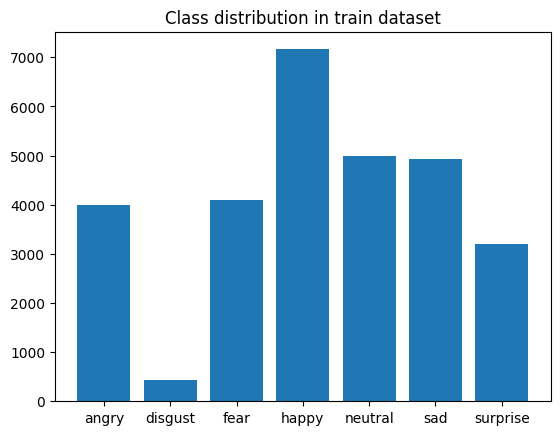

In [17]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes

# print(class_names)
# print(len(class_names))

D_t = dict(Counter(image_datasets['train'].targets))
plt.bar(range(len(D_t)), list(D_t.values()), align='center')
plt.xticks(range(len(D_t)), class_names)
plt.title('Class distribution in train dataset')
plt.show()

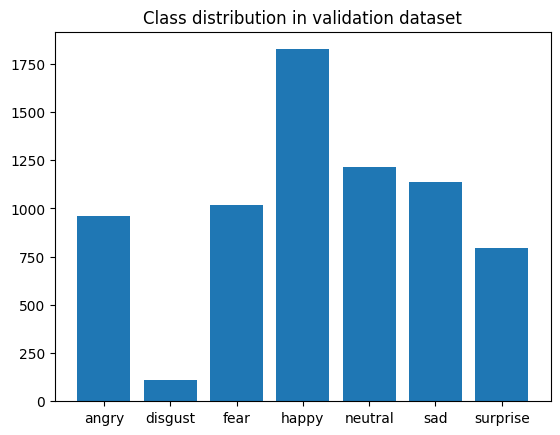

In [73]:
D_v = dict(Counter(image_datasets['validation'].targets))
plt.bar(range(len(D_v)), list(D_v.values()), align='center')
plt.xticks(range(len(D_v)), class_names)
plt.title('Class distribution in validation dataset')
plt.show()

Show random image from dataset

angry


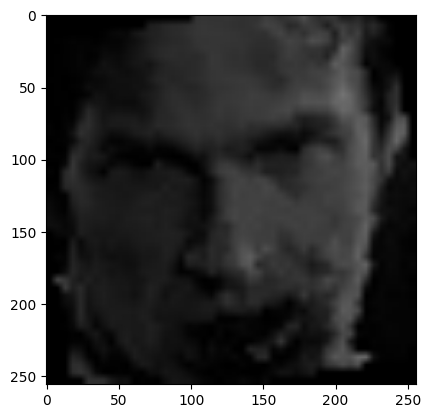

In [18]:
ri = random.randint(0,len(image_datasets['train']))
plt.imshow(image_datasets['train'].__getitem__(ri)[0].permute(1, 2, 0))
print(class_names[image_datasets['train'].__getitem__(ri)[1]])


Early stopper

In [19]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [22]:
early_stopper = EarlyStopper(patience=3, min_delta=0.05)

Train function

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            with tqdm(dataloaders[phase], unit="batch") as tepoch:
                for inputs, labels in tepoch:
                    tepoch.set_description(f"Epoch {epoch}")
                    inputs = inputs.to(device)
                    labels = labels.to(device)


                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            # early stopper
            if phase == 'validation' and early_stopper.early_stop(epoch_loss):             
                break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Model downloading, initializing , optimizer choosing

In [20]:
# model_ft = models.resnet18(pretrained=True)
model_ft = EfficientNet.from_pretrained('efficientnet-b0') #https://github.com/lukemelas/EfficientNet-PyTorch
# print(model_ft)

num_ftrs = model_ft._fc.in_features
# model_ft._fc = nn.Linear(num_ftrs, 7)
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1280,512)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.4)),
    ('fc2', nn.Linear(512,7))
#     ('output', nn.Softmax(dim=1))
]))
model_ft._fc = fc
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft =  optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft = optim.AdamW(model_ft.parameters(),lr=10e-5)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b0


In [25]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------


Epoch 0: 100%|██████████| 226/226 [01:28<00:00,  2.56batch/s]


train Loss: 1.5815 Acc: 0.3855


Epoch 0: 100%|██████████| 56/56 [00:17<00:00,  3.29batch/s]


validation Loss: 1.8930 Acc: 0.1922

Epoch 1/14
----------


Epoch 1: 100%|██████████| 226/226 [01:26<00:00,  2.63batch/s]


train Loss: 1.1259 Acc: 0.5752


Epoch 1: 100%|██████████| 56/56 [00:17<00:00,  3.28batch/s]


validation Loss: 1.2888 Acc: 0.5134

Epoch 2/14
----------


Epoch 2: 100%|██████████| 226/226 [01:26<00:00,  2.62batch/s]


train Loss: 0.9654 Acc: 0.6338


Epoch 2: 100%|██████████| 56/56 [00:17<00:00,  3.27batch/s]


validation Loss: 1.0731 Acc: 0.6066

Epoch 3/14
----------


Epoch 3: 100%|██████████| 226/226 [01:26<00:00,  2.62batch/s]


train Loss: 0.9007 Acc: 0.6607


Epoch 3: 100%|██████████| 56/56 [00:17<00:00,  3.27batch/s]


validation Loss: 1.0100 Acc: 0.6378

Epoch 4/14
----------


Epoch 4: 100%|██████████| 226/226 [01:26<00:00,  2.63batch/s]


train Loss: 0.8259 Acc: 0.6902


Epoch 4: 100%|██████████| 56/56 [00:17<00:00,  3.27batch/s]


validation Loss: 0.9727 Acc: 0.6622

Epoch 5/14
----------


Epoch 5: 100%|██████████| 226/226 [01:25<00:00,  2.63batch/s]


train Loss: 0.7877 Acc: 0.7034


Epoch 5: 100%|██████████| 56/56 [00:17<00:00,  3.27batch/s]


validation Loss: 0.9796 Acc: 0.6697

Epoch 6/14
----------


Epoch 6: 100%|██████████| 226/226 [01:26<00:00,  2.62batch/s]


train Loss: 0.7451 Acc: 0.7198


Epoch 6: 100%|██████████| 56/56 [00:17<00:00,  3.27batch/s]


validation Loss: 1.0412 Acc: 0.6574

Epoch 7/14
----------


Epoch 7: 100%|██████████| 226/226 [01:26<00:00,  2.61batch/s]


train Loss: 0.7085 Acc: 0.7326


Epoch 7: 100%|██████████| 56/56 [00:17<00:00,  3.25batch/s]


validation Loss: 1.0169 Acc: 0.6701

Epoch 8/14
----------


Epoch 8: 100%|██████████| 226/226 [01:26<00:00,  2.63batch/s]


train Loss: 0.6854 Acc: 0.7452


Epoch 8: 100%|██████████| 56/56 [00:16<00:00,  3.30batch/s]


validation Loss: 1.0063 Acc: 0.6690

Epoch 9/14
----------


Epoch 9: 100%|██████████| 226/226 [01:25<00:00,  2.64batch/s]


train Loss: 0.6770 Acc: 0.7492


Epoch 9: 100%|██████████| 56/56 [00:17<00:00,  3.25batch/s]


validation Loss: 0.9755 Acc: 0.6763

Epoch 10/14
----------


Epoch 10: 100%|██████████| 226/226 [01:26<00:00,  2.63batch/s]


train Loss: 0.6677 Acc: 0.7502


Epoch 10: 100%|██████████| 56/56 [00:16<00:00,  3.30batch/s]


validation Loss: 1.0174 Acc: 0.6704

Epoch 11/14
----------


Epoch 11: 100%|██████████| 226/226 [01:25<00:00,  2.63batch/s]


train Loss: 0.6720 Acc: 0.7483


Epoch 11: 100%|██████████| 56/56 [00:17<00:00,  3.26batch/s]


validation Loss: 1.0294 Acc: 0.6809

Epoch 12/14
----------


Epoch 12: 100%|██████████| 226/226 [01:26<00:00,  2.63batch/s]


train Loss: 0.6580 Acc: 0.7551


Epoch 12: 100%|██████████| 56/56 [00:17<00:00,  3.29batch/s]


validation Loss: 0.9855 Acc: 0.6804

Epoch 13/14
----------


Epoch 13: 100%|██████████| 226/226 [01:26<00:00,  2.62batch/s]


train Loss: 0.6450 Acc: 0.7580


Epoch 13: 100%|██████████| 56/56 [00:17<00:00,  3.26batch/s]


validation Loss: 1.0297 Acc: 0.6681

Epoch 14/14
----------


Epoch 14: 100%|██████████| 226/226 [01:25<00:00,  2.63batch/s]


train Loss: 0.6533 Acc: 0.7570


Epoch 14: 100%|██████████| 56/56 [00:17<00:00,  3.26batch/s]

validation Loss: 1.0305 Acc: 0.6768

Training complete in 25m 51s
Best val Acc: 0.680866


Saving weights

In [26]:
PATH = './efficientnet_b0_adamw_256x256_2.pt'
torch.save(model_ft, PATH)

In [27]:
torch.save(model_ft.state_dict(), 'model_weights_eff_net_b0_adamW_256x256_2.pth')

Loading weights for evaluation

In [22]:
model_ft.load_state_dict(torch.load('model_weights_eff_net_b0_adamW_256x256_2.pth'))
model_ft.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

Predict single example

fear


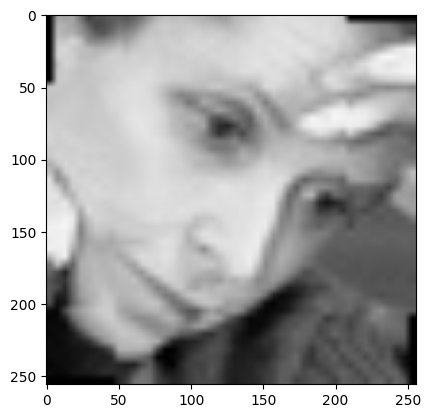

In [23]:
ri = random.randint(0,28820)
plt.imshow(image_datasets['train'].__getitem__(ri)[0].permute(1, 2, 0))
print(class_names[image_datasets['train'].__getitem__(ri)[1]])

Answer = surprise
-----
surprise                                                                    (99.04%)
fear                                                                        (0.41%)
neutral                                                                     (0.32%)
happy                                                                       (0.11%)
angry                                                                       (0.09%)
sad                                                                         (0.03%)
disgust                                                                     (0.00%)
CPU times: total: 672 ms
Wall time: 55.1 ms


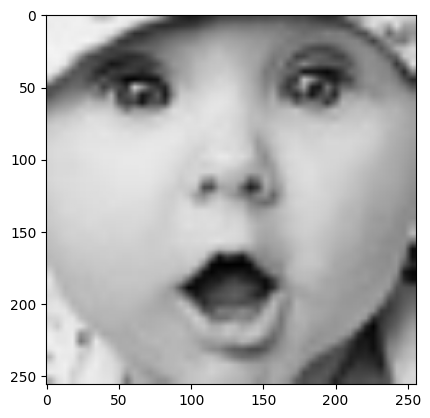

In [37]:
%%time
ri = random.randint(0,len(image_datasets['validation'])-1)
plt.imshow(image_datasets['validation'].__getitem__(ri)[0].permute(1, 2, 0))
print('Answer =',class_names[image_datasets['validation'].__getitem__(ri)[1]])

model_ft.eval()

img = image_datasets['validation'].__getitem__(ri)[0].to(device)

with torch.no_grad():
    outputs = model_ft(img.unsqueeze(0))

# Print predictions
print('-----')
for idx in torch.topk(outputs, k=7).indices.squeeze(0).tolist():
    prob = torch.softmax(outputs, dim=1)[0, idx].item()
    print('{label:<75} ({p:.2f}%)'.format(label=class_names[idx], p=prob*100))


# print(outputs)
# print(class_names)
# print(prob)

Clearing cache

In [39]:
torch.cuda.empty_cache()
import gc
gc.collect()

6676

Quantization

Dynamic_quantization

In [86]:
import torch.quantization

In [87]:
quantized_model_ft = torch.quantization.quantize_dynamic(
    model_ft, {nn.Sequential,nn.Conv2d, nn.Linear}, dtype=torch.qint8
)

In [91]:
quantized_model_ft

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [89]:
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

In [90]:
# Only last layers was quantized, so i don't see large improvement in size ~12%
# Convolutional layers was not quantized

# compare the sizes
f=print_size_of_model(model_ft,"fp32")
q=print_size_of_model(quantized_model_ft,"int8")
print("{0:.2f} times smaller".format(f/q))

model:  fp32  	 Size (KB): 18941.353
model:  int8  	 Size (KB): 16966.037
1.12 times smaller


In [115]:
quantized_model_ft.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [121]:
#However we have errors with that model on inference

quantized_model_ft.eval()
img = image_datasets['validation'].__getitem__(ri)[0].to(device)
quantized_model_ft(img.unsqueeze(0))

NotImplementedError: Could not run 'quantized::linear_dynamic' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::linear_dynamic' is only available for these backends: [CPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PythonDispatcher].

CPU: registered at ..\aten\src\ATen\native\quantized\cpu\qlinear_dynamic.cpp:656 [kernel]
BackendSelect: fallthrough registered at ..\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:140 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ..\aten\src\ATen\functorch\DynamicLayer.cpp:488 [backend fallback]
Functionalize: registered at ..\aten\src\ATen\FunctionalizeFallbackKernel.cpp:291 [backend fallback]
Named: registered at ..\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ..\aten\src\ATen\ConjugateFallback.cpp:18 [backend fallback]
Negative: registered at ..\aten\src\ATen\native\NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at ..\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:64 [backend fallback]
AutogradOther: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:35 [backend fallback]
AutogradCPU: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:39 [backend fallback]
AutogradCUDA: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:47 [backend fallback]
AutogradXLA: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:51 [backend fallback]
AutogradMPS: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:59 [backend fallback]
AutogradXPU: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:43 [backend fallback]
AutogradHPU: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:68 [backend fallback]
AutogradLazy: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:55 [backend fallback]
Tracer: registered at ..\torch\csrc\autograd\TraceTypeManual.cpp:296 [backend fallback]
AutocastCPU: fallthrough registered at ..\aten\src\ATen\autocast_mode.cpp:482 [backend fallback]
AutocastCUDA: fallthrough registered at ..\aten\src\ATen\autocast_mode.cpp:324 [backend fallback]
FuncTorchBatched: registered at ..\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:743 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ..\aten\src\ATen\functorch\VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at ..\aten\src\ATen\BatchingRegistrations.cpp:1064 [backend fallback]
VmapMode: fallthrough registered at ..\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ..\aten\src\ATen\functorch\TensorWrapper.cpp:189 [backend fallback]
PythonTLSSnapshot: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:148 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ..\aten\src\ATen\functorch\DynamicLayer.cpp:484 [backend fallback]
PythonDispatcher: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:144 [backend fallback]


Answer = happy


NotImplementedError: Could not run 'quantized::linear_dynamic' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::linear_dynamic' is only available for these backends: [CPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PythonDispatcher].

CPU: registered at ..\aten\src\ATen\native\quantized\cpu\qlinear_dynamic.cpp:656 [kernel]
BackendSelect: fallthrough registered at ..\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:140 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ..\aten\src\ATen\functorch\DynamicLayer.cpp:488 [backend fallback]
Functionalize: registered at ..\aten\src\ATen\FunctionalizeFallbackKernel.cpp:291 [backend fallback]
Named: registered at ..\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ..\aten\src\ATen\ConjugateFallback.cpp:18 [backend fallback]
Negative: registered at ..\aten\src\ATen\native\NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at ..\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:64 [backend fallback]
AutogradOther: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:35 [backend fallback]
AutogradCPU: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:39 [backend fallback]
AutogradCUDA: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:47 [backend fallback]
AutogradXLA: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:51 [backend fallback]
AutogradMPS: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:59 [backend fallback]
AutogradXPU: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:43 [backend fallback]
AutogradHPU: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:68 [backend fallback]
AutogradLazy: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:55 [backend fallback]
Tracer: registered at ..\torch\csrc\autograd\TraceTypeManual.cpp:296 [backend fallback]
AutocastCPU: fallthrough registered at ..\aten\src\ATen\autocast_mode.cpp:482 [backend fallback]
AutocastCUDA: fallthrough registered at ..\aten\src\ATen\autocast_mode.cpp:324 [backend fallback]
FuncTorchBatched: registered at ..\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:743 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ..\aten\src\ATen\functorch\VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at ..\aten\src\ATen\BatchingRegistrations.cpp:1064 [backend fallback]
VmapMode: fallthrough registered at ..\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ..\aten\src\ATen\functorch\TensorWrapper.cpp:189 [backend fallback]
PythonTLSSnapshot: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:148 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ..\aten\src\ATen\functorch\DynamicLayer.cpp:484 [backend fallback]
PythonDispatcher: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:144 [backend fallback]


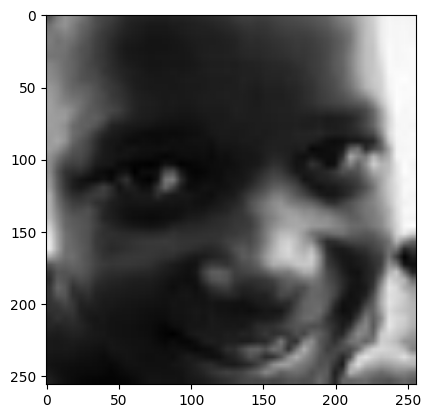

In [116]:
%%time
ri = random.randint(0,len(image_datasets['validation'])-1)
plt.imshow(image_datasets['validation'].__getitem__(ri)[0].permute(1, 2, 0))
print('Answer =',class_names[image_datasets['validation'].__getitem__(ri)[1]])

quantized_model_ft.eval()

img = image_datasets['validation'].__getitem__(ri)[0].to(device)

with torch.no_grad():
    outputs = quantized_model_ft(img.unsqueeze(0))

# Print predictions
print('-----')
for idx in torch.topk(outputs, k=7).indices.squeeze(0).tolist():
    prob = torch.softmax(outputs, dim=1)[0, idx].item()
    print('{label:<75} ({p:.2f}%)'.format(label=class_names[idx], p=prob*100))

quantized_model_ft

Post-Training Static Quantization (PTQ)

In [94]:
model_ft.qconfig

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})

In [98]:
random.sample(range(7000), 10)

[5649, 3169, 5201, 1887, 4279, 1561, 1359, 2108, 1469, 511]

In [103]:
backend = "fbgemm"

## EAGER MODE
m = copy.deepcopy(model)
m.eval()

model_ft.qconfig = torch.quantization.get_default_qconfig(backend)
torch.backends.quantized.engine = backend
model_ft_static_quantized = torch.quantization.prepare(model_ft, inplace=False)

with torch.inference_mode():
  for ri in random.sample(range(7000), 10):
    x = image_datasets['validation'].__getitem__(ri)[0].to(device)
    model_ft_static_quantized(x.unsqueeze(0))

model_ft_static_quantized = torch.quantization.convert(model_ft_static_quantized, inplace=False)

RuntimeError: Unsupported qscheme: per_channel_affine

ONNX

In [239]:
resize = transforms.Resize([256, 256])

In [254]:

model_ft_exp = model_ft
model_ft_exp.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [273]:
img.unsqueeze(0).shape

torch.Size([1, 3, 256, 256])

In [276]:
# dummy_input = resize(torch.randn(1, 3, 256, 256,requires_grad=True)).to(device)
dummy_input = img.unsqueeze(0).to(device)

# with torch.no_grad():
#     outputs = model_ft_exp(img.unsqueeze(0))
# outputs

In [277]:
dummy_input.shape

torch.Size([1, 3, 256, 256])

In [278]:

torch_out = model_ft_exp(dummy_input)

model_ft_exp.set_swish(memory_efficient=False)
torch.onnx.export(model_ft_exp, dummy_input,
                 "Eff_net_emotions.onnx", verbose=True,
                 )
                

C:\Users\beori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\onnx\_internal\jit_utils.py:258: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ..\torch\csrc\jit\passes\onnx\constant_fold.cpp:181.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
C:\Users\beori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\onnx\utils.py:687: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ..\torch\csrc\jit\passes\onnx\constant_fold.cpp:181.)
  _C._jit_pass_onnx_graph_shape_type_inference(
C:\Users\beori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag

In [279]:
torch_out

tensor([[-1.7699, -6.9479,  0.3253,  5.0495,  0.2382, -2.3418,  1.3951]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

ONNX API

In [280]:
import onnx

In [281]:
onnx_model = onnx.load("Eff_net_emotions.onnx")
onnx.checker.check_model(onnx_model)

Verify that ONNX Runtime and PyTorch are computing the same value for the network

In [282]:
import onnxruntime


In [284]:
ort_session = onnxruntime.InferenceSession("Eff_net_emotions.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(dummy_input)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
# np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-02, atol=1e-04) # i've set tolerances to bigger values to pass the test

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


In [285]:
ort_outs[0]

array([[-1.7673357 , -6.9450417 ,  0.32361212,  5.051091  ,  0.23600248,
        -2.3419878 ,  1.3932265 ]], dtype=float32)

In [286]:
torch_out

tensor([[-1.7699, -6.9479,  0.3253,  5.0495,  0.2382, -2.3418,  1.3951]],
       device='cuda:0', grad_fn=<AddmmBackward0>)